<a href="https://colab.research.google.com/github/BOLLOJUAISHWARYA/Time_series/blob/main/LSTM_and_GRU_multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
#Importing libraries and loading dataset
import numpy as np
from datetime import datetime
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM

In [60]:
df = read_csv('/content/drive/MyDrive/Datasets/pollution.csv')
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [61]:
#parsing datetime
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
                        
df = read_csv('/content/drive/MyDrive/Datasets/pollution.csv',index_col=0, date_parser=parse,parse_dates=[['year', 'month', 'day', 'hour']])  


In [62]:
df.head(5)

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [63]:
df.isnull().sum()

No          0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [64]:
# Data cleaning
col_names = ['pollution', 'dew', 'temp', 'pressure', 'wind_dir', 'wind_speed', 'snow', 'rain']   
df.drop('No', axis=1, inplace=True)
df.columns = col_names
df = df[24:] # droped the first day as the values are nan 
df['pollution'].fillna(0, inplace=True)#replaced rest of the nan values 
print(df.head(5))
df.to_csv('pollution_data.csv') # save new CSV

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


                     pollution  dew  temp  pressure wind_dir  wind_speed  \
year_month_day_hour                                                        
2010-01-02 00:00:00      129.0  -16  -4.0    1020.0       SE        1.79   
2010-01-02 01:00:00      148.0  -15  -4.0    1020.0       SE        2.68   
2010-01-02 02:00:00      159.0  -11  -5.0    1021.0       SE        3.57   
2010-01-02 03:00:00      181.0   -7  -5.0    1022.0       SE        5.36   
2010-01-02 04:00:00      138.0   -7  -5.0    1022.0       SE        6.25   

                     snow  rain  
year_month_day_hour              
2010-01-02 00:00:00     0     0  
2010-01-02 01:00:00     0     0  
2010-01-02 02:00:00     0     0  
2010-01-02 03:00:00     1     0  
2010-01-02 04:00:00     2     0  


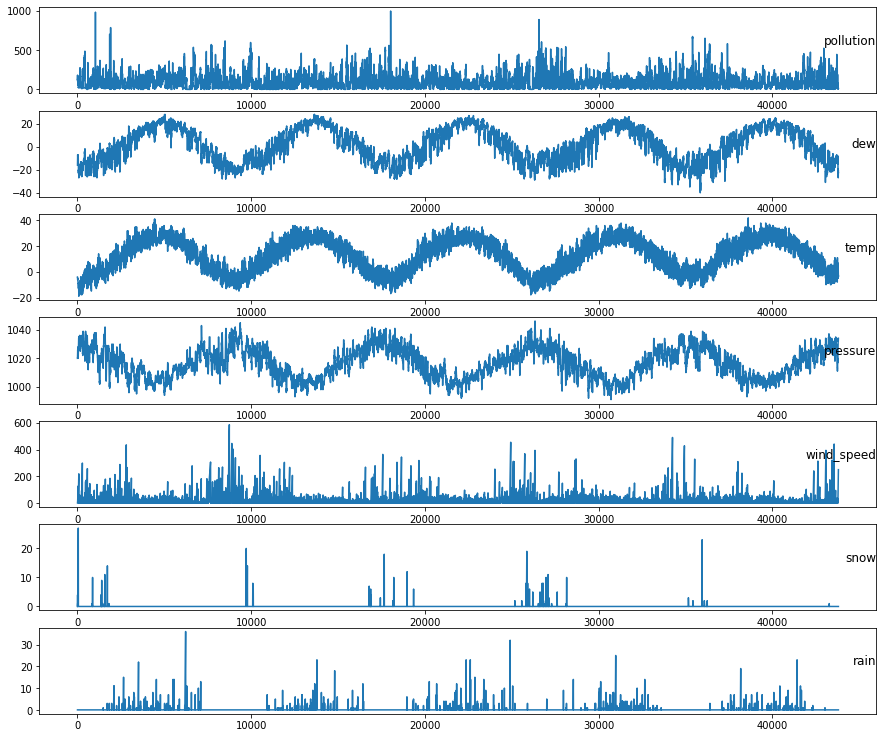

In [65]:
#visualizatiion
dataset = read_csv('pollution_data.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure(figsize=(15,13))
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [66]:
# wind direction is categorical so label encoded it
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalized the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)
scaled_dataset


array([[0.12977867, 0.35294122, 0.24590163, ..., 0.00229001, 0.        ,
        0.        ],
       [0.14889336, 0.36764708, 0.24590163, ..., 0.00381099, 0.        ,
        0.        ],
       [0.15995975, 0.4264706 , 0.22950819, ..., 0.00533197, 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.41399646, 0.        ,
        0.        ],
       [0.00804829, 0.2647059 , 0.24590163, ..., 0.4208665 , 0.        ,
        0.        ],
       [0.01207243, 0.2794118 , 0.26229507, ..., 0.42621556, 0.        ,
        0.        ]], dtype=float32)

In [67]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 4
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y


In [68]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)

Y (43796, 1)
X (43796, 4, 8)


In [69]:
#Splitting the dataset
n_train = 24*365
train_X, test_X = X[n_train:,] , X[:n_train,]
print('train_X' ,train_X.shape)
print('test_X' ,test_X.shape)

train_y, test_y = Y[n_train:,] , Y[:n_train,]
print('train_y' ,train_y.shape)
print('test_y' ,test_y.shape)


train_X (35036, 4, 8)
test_X (8760, 4, 8)
train_y (35036, 1)
test_y (8760, 1)


In [70]:
# model
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
487/487 - 5s - loss: 0.0402 - val_loss: 0.0336 - 5s/epoch - 10ms/step
Epoch 2/50
487/487 - 2s - loss: 0.0235 - val_loss: 0.0262 - 2s/epoch - 5ms/step
Epoch 3/50
487/487 - 2s - loss: 0.0200 - val_loss: 0.0204 - 2s/epoch - 5ms/step
Epoch 4/50
487/487 - 2s - loss: 0.0174 - val_loss: 0.0182 - 2s/epoch - 5ms/step
Epoch 5/50
487/487 - 2s - loss: 0.0161 - val_loss: 0.0155 - 2s/epoch - 5ms/step
Epoch 6/50
487/487 - 2s - loss: 0.0152 - val_loss: 0.0155 - 2s/epoch - 5ms/step
Epoch 7/50
487/487 - 2s - loss: 0.0148 - val_loss: 0.0151 - 2s/epoch - 5ms/step
Epoch 8/50
487/487 - 2s - loss: 0.0148 - val_loss: 0.0146 - 2s/epoch - 5ms/step
Epoch 9/50
487/487 - 3s - loss: 0.0146 - val_loss: 0.0148 - 3s/epoch - 5ms/step
Epoch 10/50
487/487 - 2s - loss: 0.0145 - val_loss: 0.0147 - 2s/epoch - 5ms/step
Epoch 11/50
487/487 - 2s - loss: 0.0144 - val_loss: 0.0158 - 2s/epoch - 5ms/step
Epoch 12/50
487/487 - 2s - loss: 0.0144 - val_loss: 0.0151 - 2s/epoch - 5ms/step
Epoch 13/50
487/487 - 2s - loss: 0.0

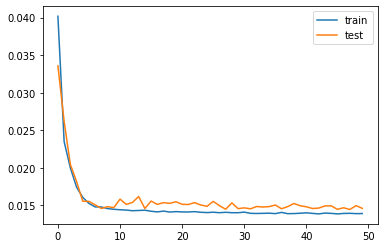

In [71]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [72]:
Y_pred = model.predict(test_X)

mse = mean_squared_error(test_y, Y_pred)

rmse = np.sqrt(mse)
rmse

0.03296532

In [73]:
print('y_predicted',Y_pred.shape)

y_predicted (8760, 1)


In [74]:
Y_pred

array([[0.18830992],
       [0.12896082],
       [0.10150839],
       ...,
       [0.03570832],
       [0.0304438 ],
       [0.01845106]], dtype=float32)

In [75]:
#Scaling back to the original scale
d = scaled_dataset[:8760,:]
Y_predicted = np.concatenate((Y_pred,d[:8760,1:]), axis =1)
print('concat y_pred',Y_pred.shape)
Y_tested = np.concatenate((test_y, d[:8760,1:]), axis = 1)
print('concat Y_test', test_y.shape)

concat y_pred (8760, 1)
concat Y_test (8760, 1)


In [76]:
Y_predicted[1]

array([0.12896082, 0.36764708, 0.24590163, 0.5272732 , 0.6666667 ,
       0.00381099, 0.        , 0.        ], dtype=float32)

In [77]:
Y_predicted = scaler.inverse_transform(Y_predicted)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
print('Y_tested', Y_tested.shape)
print('Y_predicted', Y_predicted.shape)

Y_tested (8760, 1)
Y_predicted (8760, 1)


In [78]:
Y_predicted

array([[187.18007 ],
       [128.18706 ],
       [100.899345],
       ...,
       [ 35.494072],
       [ 30.26114 ],
       [ 18.340359]], dtype=float32)

In [79]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_tested, Y_predicted)

rmse = np.sqrt(mse)
rmse

32.767532

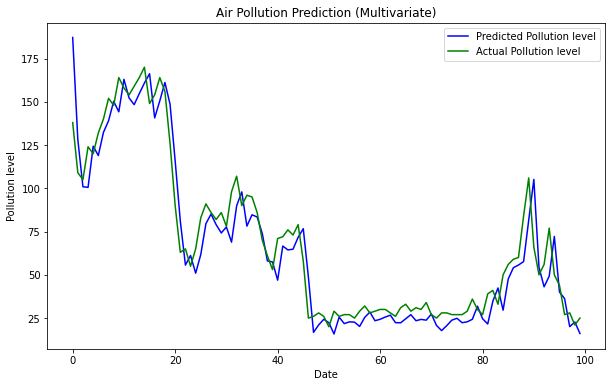

<Figure size 432x288 with 0 Axes>

In [80]:
#Plot the graph between actual vs predicted values
pyplot.figure(figsize=(10,6))  
pyplot.plot(Y_predicted[:100,:], color= 'blue',label = 'Predicted Pollution level')
pyplot.plot(Y_tested[:100,:] , color = 'green',label = 'Actual Pollution level')
pyplot.title("Air Pollution Prediction (Multivariate)")
pyplot.xlabel("Date")
pyplot.ylabel("Pollution level")
pyplot.legend()
pyplot.show()
pyplot.savefig('graph.png')

In [81]:
#Splitting the dataset
n_train = 24*365
train_X, test_X = X[n_train:,] , X[:n_train,]
print('train_X' ,train_X.shape)
print('test_X' ,test_X.shape)

train_y, test_y = Y[n_train:,] , Y[:n_train,]
print('train_y' ,train_y.shape)
print('test_y' ,test_y.shape)


train_X (35036, 4, 8)
test_X (8760, 4, 8)
train_y (35036, 1)
test_y (8760, 1)


In [82]:
# model
model_gru = Sequential()
model_gru.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru.add(Dropout(0.2))

model_gru.add(Dense(units = 1))
model_gru.compile(loss='mae', optimizer='adam')
# fit network
history = model_gru.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
487/487 - 6s - loss: 0.0398 - val_loss: 0.0294 - 6s/epoch - 12ms/step
Epoch 2/50
487/487 - 2s - loss: 0.0232 - val_loss: 0.0280 - 2s/epoch - 5ms/step
Epoch 3/50
487/487 - 2s - loss: 0.0193 - val_loss: 0.0177 - 2s/epoch - 5ms/step
Epoch 4/50
487/487 - 2s - loss: 0.0171 - val_loss: 0.0164 - 2s/epoch - 5ms/step
Epoch 5/50
487/487 - 2s - loss: 0.0157 - val_loss: 0.0149 - 2s/epoch - 5ms/step
Epoch 6/50
487/487 - 2s - loss: 0.0150 - val_loss: 0.0158 - 2s/epoch - 5ms/step
Epoch 7/50
487/487 - 2s - loss: 0.0149 - val_loss: 0.0156 - 2s/epoch - 5ms/step
Epoch 8/50
487/487 - 2s - loss: 0.0146 - val_loss: 0.0163 - 2s/epoch - 5ms/step
Epoch 9/50
487/487 - 2s - loss: 0.0145 - val_loss: 0.0154 - 2s/epoch - 5ms/step
Epoch 10/50
487/487 - 2s - loss: 0.0145 - val_loss: 0.0152 - 2s/epoch - 5ms/step
Epoch 11/50
487/487 - 2s - loss: 0.0144 - val_loss: 0.0153 - 2s/epoch - 5ms/step
Epoch 12/50
487/487 - 2s - loss: 0.0144 - val_loss: 0.0152 - 2s/epoch - 5ms/step
Epoch 13/50
487/487 - 2s - loss: 0.0

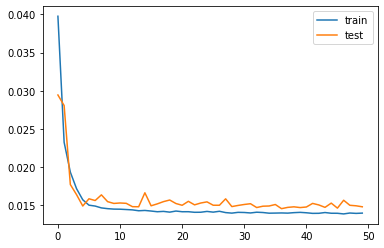

In [83]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [84]:
#Scaling back to the original scale
d = scaled_dataset[:8760,:]
Y_predicted = np.concatenate((Y_pred,d[:8760,1:]), axis =1)
print('concat y_pred',Y_pred.shape)
Y_tested = np.concatenate((test_y, d[:8760,1:]), axis = 1)
print('concat Y_test', test_y.shape)

concat y_pred (8760, 1)
concat Y_test (8760, 1)


In [85]:
Y_predicted = scaler.inverse_transform(Y_predicted)
Y_tested = scaler.inverse_transform(Y_tested)
Y_predicted = Y_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
print('Y_tested', Y_tested.shape)
print('Y_predicted', Y_predicted.shape)

Y_tested (8760, 1)
Y_predicted (8760, 1)


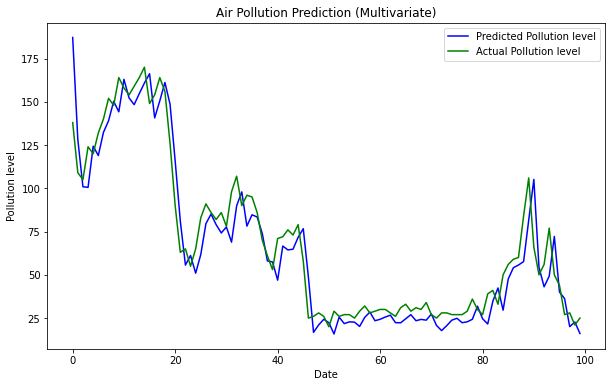

<Figure size 432x288 with 0 Axes>

In [86]:
#Plot the graph between actual vs predicted values
pyplot.figure(figsize=(10,6))  
pyplot.plot(Y_predicted[:100,:], color= 'blue',label = 'Predicted Pollution level')
pyplot.plot(Y_tested[:100,:] , color = 'green',label = 'Actual Pollution level')
pyplot.title("Air Pollution Prediction (Multivariate)")
pyplot.xlabel("Date")
pyplot.ylabel("Pollution level")
pyplot.legend()
pyplot.show()
pyplot.savefig('graph.png')